In [1]:
library(reticulate)
library(ggplot2)
library(dplyr)
library(reshape2)
options(repr.plot.width=4, repr.plot.height=3)



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [2]:
NormalizeLogX <- function(x) {
    max_x <- max(x)
    return(x  - max_x - log(sum(exp(x - max_x))))
}

SetT <- function(t_val, margin, model) {
    t_x_vec <- array(0, dim=(model$dim))
    t_x_vec[margin] <- t_val
    model$t_x <- t_x_vec
    eff_num_samples_x <- model$set_moments_par()[[1]]
    return(eff_num_samples_x)
}

OptimizeForT <- function(t_val, margin, model) {
    cat("Running for ", t_val, "\n")
    eff_num_samples_x <- SetT(t_val, margin, model)
    q_opt <- model$optimize_q()
    map_opt <- model$optimize_map()
    df <- data.frame(model$get_combined_moment_df())
    df$eff_samp <- eff_num_samples_x
    df$t <- t_val
    df$t_margin <- margin
    df$q_opt_message <- q_opt$message
    df$map_opt_message <- map_opt$message
    return(df)    
}

GetLogProbForT <- function(t_vals, model) {
    LPForSingleT <- function(t_val, x_grid, model) {
        SetT(t_val, 1, model)
        lp <- NormalizeLogX(model$get_log_prob(x_grid))
        return(data.frame(x_grid=x_grid, lp=lp, t=t_val))
    }
    lp_t_df <- do.call(rbind, lapply(
        t_vals, function(x) { LPForSingleT(x, x_grid, model)}))
    lp_t_df$p <- exp(lp_t_df$lp)
    return(lp_t_df)
}


GetMeanDataFrame <- function(moment_df) {
    true_mean <- filter(moment_df, method == "truth", metric == "mean")$value
    vb_mean <- filter(moment_df, method == "mfvb", metric == "mean")$value
    map_mean <- filter(moment_df, method == "map", metric == "mean")$value
    mean_df <- rbind(
        data.frame(mean=t(true_mean), method="truth"),
        data.frame(mean=t(vb_mean), method="mfvb"),
        data.frame(mean=t(map_mean), method="map"))
    return(mean_df)
}

Get1dPlotDataFrame <- function(x_grid, model) {
    lp <- NormalizeLogX(model$get_log_prob(x_grid))
    q_lp <- NormalizeLogX(model$q$get_log_prob(x_grid))
    map_lp <- NormalizeLogX(model$get_map_log_prob(x_grid))

    x_df <- data.frame(x_grid)
    names(x_df) <- paste("x", 1:ncol(x_grid), sep="")
    lp_df <- rbind(
        cbind(x_df, data.frame(lp=lp, method="truth", p=exp(lp))),
        cbind(x_df, data.frame(lp=q_lp, method="mfvb", p=exp(q_lp))),
        cbind(x_df, data.frame(lp=map_lp, method="map", p=exp(map_lp)))
    )

    moment_df <- model$get_combined_moment_df()
    mean_df <-GetMeanDataFrame(moment_df)
    plot_df <- inner_join(lp_df, mean_df, by="method")
    stopifnot(nrow(plot_df) == nrow(lp_df))
    
    return(plot_df)
}


GetTGraphDataFrame <- function(t_result_df) {
    t_result_plot_df <-
        inner_join(t_result_df, filter(t_result_df, t == 0) %>% select(-t),
                   by=c("dims", "metric", "method"),
                   suffix=c("", "_base")) %>%
        mutate(value_diff=value - value_base)
    return(t_result_plot_df)
}

# This is the number of draws used for the approximate KL divergence.
NumVBSims <- as.integer(10000)




In [3]:
git_repo_loc <- "/home/rgiordan/Documents/git_repos/"
use_python("/usr/bin/python3")
`%_%` <- function(x, y) { paste(x, y, sep="")}

# This depends on having local clones in `git_repo_loc` of the following repositories:
# https://github.com/rgiordan/LinearResponseVariationalBayes.py
# https://github.com/HIPS/autograd

main <- reticulate::import_main()
py_run_string("import sys")
for (py_lib in c("LinearResponseVariationalBayes.py",
                 "CovariancesRobustnessVBPaper/code/simple_examples/",
                 "autograd")) {
    py_run_string("sys.path.append('" %_% file.path(git_repo_loc, py_lib) %_% "')")
}
py_run_string("
import LinearResponseVariationalBayes as vb
import LinearResponseVariationalBayes.SparseObjectives as obj_lib
from autograd import numpy as np
import scipy as sp
import pandas as pd

import numpy as onp
import multivariate_model_lib
import mixture_2d_lib
")

# A 1d model with some skew

Here, we fit a simple one-dimensional distribution with some skew.  We show that the VB solution approximates the true mean better than the MAP because of its ability to take into account skew information.  Tilting by $tx$ skews the distribtuion still further, and the VB approximation remains reasonably accurate for small $t$.

[[1]]
[1] 10000

[[2]]
[1] 10000

Dict (11 items)

Dict (11 items)

  metric dims     lrvb       map     mfvb    truth
1   mean    0       NA 0.1114448 1.301577 1.251067
2    var    0 3.326512 0.8492092 2.520799 2.927850


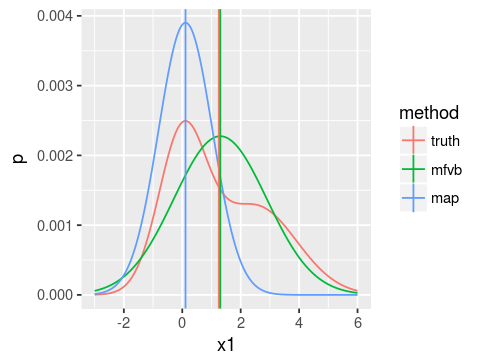

In [4]:
py_run_string("
model = mixture_2d_lib.MixtureModel(dim=1, num_components=2)
model.mix_par['loc'].set(np.array([[0], [2.5]]))
model.mix_par['info'].set(np.array([ [[1.5]], [[0.5]] ]))
model.mix_par['w'].set(np.array([[ 0.5, 0.5]]))
")
main$model$q$set_draws(NumVBSims)
main$model$zero_tilt()
main$model$set_monte_carlo_draws(10000)
main$model$set_moments_par()
main$model$optimize_q()
main$model$optimize_map()

moment_df <- main$model$get_combined_moment_df()
x_grid <- matrix(seq(-3, 6, length.out=1000))
plot_df <- Get1dPlotDataFrame(x_grid, main$model)
ggplot(plot_df) +
    geom_line(aes(x=x1, y=p, color=method)) +
    geom_vline(aes(xintercept=mean, color=method))

print(dcast(moment_df, metric + dims ~ method, value.var="value"))

Tilting skews the distribution still further.

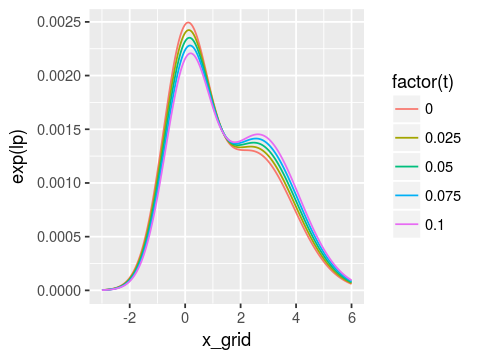

In [5]:
t_vals <- seq(0, 0.1, length.out=5)
lp_t_df <- GetLogProbForT(t_vals, main$model)
ggplot(lp_t_df) + 
    geom_line(aes(x=x_grid, y=exp(lp), color=factor(t)))

The VB mean remains pretty accurate for different values of $t$, whereas the MAP estimate of the mean increases too slowly.

In [6]:
t_results <- lapply(seq(0, 0.1, length.out=5), function(x) { OptimizeForT(x, 1, main$model) })

Running for  0 
Running for  0.025 
Running for  0.05 
Running for  0.075 
Running for  0.1 


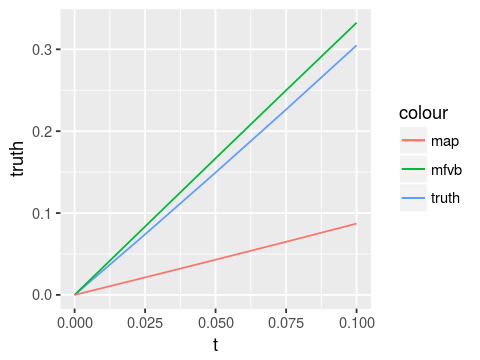

In [7]:
t_result_df <- do.call(rbind, t_results)
t_result_plot_df <- GetTGraphDataFrame(t_result_df) 

ggplot(filter(t_result_plot_df, metric == "mean", dims == 0) %>%
        dcast(dims + metric + t ~ method, value.var=c("value_diff"))) +
    geom_line(aes(x=t, y=truth, color="truth")) +
    geom_line(aes(x=t, y=mfvb, color="mfvb")) +
    geom_line(aes(x=t, y=map, color="map"))

In [8]:
# Save results for the paper in this list.
skew_1d <- list()
skew_1d$moment_df <- moment_df
skew_1d$plot_df <- plot_df
skew_1d$lp_t_df <- lp_t_df
skew_1d$t_result_plot_df <- t_result_plot_df

# A 1d model with no skew

Here, we consider a model with no skew, but with excess variance.  We show that, althoug the VB and MAP means are exaxctly correct by symmetry, the VB mean tracks the true mean more closely as we tilt by $tx$, for the reasons we saw in the last model -- by taking into account information away from the MAP, VB is better able to estimate the mean of skewed distributions.

[[1]]
[1] 1e+05

[[2]]
[1] 1e+05

Dict (11 items)

Dict (11 items)

  metric dims     lrvb           map       mfvb       truth
1   mean    0       NA -7.063377e-07 0.02488685 -0.00282529
2    var    0 4.283544  1.106543e+00 4.09628340  4.20068555


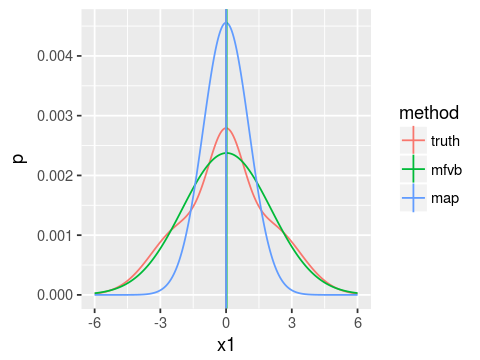

In [9]:
py_run_string("
model = mixture_2d_lib.MixtureModel(dim=1, num_components=3)
model.mix_par['loc'].set(np.array([[-2], [0], [2]]))
model.mix_par['info'].set(np.array([ [[0.5]], [[1.5]], [[0.5]] ]))
model.mix_par['w'].set(np.array([[ 1/3, 1/3, 1/3]]))
")
main$model$q$set_draws(NumVBSims)
main$model$zero_tilt()
main$model$set_monte_carlo_draws(as.integer(100000))
main$model$set_moments_par()
main$model$optimize_q()
main$model$optimize_map()

moment_df <- main$model$get_combined_moment_df()
x_grid <- matrix(seq(-6, 6, length.out=1000), ncol=1)
plot_df <- Get1dPlotDataFrame(x_grid, main$model)

ggplot(plot_df) +
    geom_line(aes(x=x1, y=p, color=method)) +
    geom_vline(aes(xintercept=mean, color=method))

print(dcast(moment_df, metric + dims ~ method, value.var="value"))

Although the base model is symmetric, as we tilt by $tx$, we introduce some skew.

In [ ]:
t_vals <- seq(0, 0.1, length.out=5)
lp_t_df <- GetLogProbForT(t_vals, main$model)
ggplot(lp_t_df) + geom_line(aes(x=x_grid, y=exp(lp), color=factor(t)))

As the model becomes skewed, the slope of the dependence of the mean on $t$ is the LRVB variance.  As we saw above, the MAP underestimates the effect of the skew on the mean, and hence the LRVB variance is better than the MAP variance.

In [ ]:
t_result_df <- do.call(rbind, lapply(t_vals, function(x) { OptimizeForT(x, 1, main$model) }))
t_result_plot_df <- GetTGraphDataFrame(t_result_df) 

ggplot(filter(t_result_plot_df, metric == "mean", dims == 0) %>%
        dcast(dims + metric + t ~ method, value.var=c("value_diff"))) +
    geom_line(aes(x=t, y=truth, color="truth")) +
    geom_line(aes(x=t, y=mfvb, color="mfvb")) +
    geom_line(aes(x=t, y=map, color="map"))

In [ ]:
# Save results for the paper in this list.
noskew_1d <- list()
noskew_1d$moment_df <- moment_df
noskew_1d$plot_df <- plot_df
noskew_1d$lp_t_df <- lp_t_df
noskew_1d$t_result_plot_df <- t_result_plot_df

# A more complex heavy-tailed bivariate model

In [ ]:
py_run_string("
num_components = 3
model = mixture_2d_lib.MixtureModel(dim=2, num_components=num_components)

delta = 1.5
sd_scale = 0.6
sd_narrowness = 0.4
w_diff = 0.15
mixture_2d_lib.set_mix_par_3comp(model, delta, sd_scale, sd_narrowness, w_diff)
")

In [ ]:
main$model$set_monte_carlo_draws(as.integer(100000))
main$model$q$set_draws(NumVBSims)
main$model$set_moments_par()
vb_opt_res <- main$model$optimize_q()
map_opt_res <- main$model$optimize_map()
moment_df <- main$model$get_combined_moment_df()

vb_opt_res$message
map_opt_res$message

print(dcast(moment_df, metric + dims ~ method, value.var="value"))

In [ ]:
grid_points <- seq(-4, 4, length.out=100)
plot_points <- as.matrix(expand.grid(grid_points, grid_points))
plot_df <- Get1dPlotDataFrame(plot_points, main$model)

ggplot(plot_df) +
    #geom_raster(aes(x=x1, y=x2, fill=p) +
    geom_contour(aes(x=x1, y=x2, z=p, color=method))

In [ ]:
py_run_string("
margin = 0
marginal_model = mixture_2d_lib.MixtureModel(dim=1, num_components=num_components)
marginal_model.mix_par = mixture_2d_lib.get_marginal_mixture_parameters(
    model.mix_par, margin=margin)
marginal_model.q.par = multivariate_model_lib.get_marginal_vb_parameters(
    model.q.par, margin=margin)
")

x_grid <- matrix(seq(-4, 4, length.out=1000))
margin_plot_df <-
    Get1dPlotDataFrame(x_grid, main$model) %>%
    rename(mean=mean.1)

ggplot(margin_plot_df) +
    geom_line(aes(x=x1, y=p, color=method)) +
    geom_vline(aes(xintercept=mean, color=method))

model_x_draws <- main$model$draws[, 1]
ggplot() +
    geom_histogram(aes(x=model_x_draws, y=..density..), bins=30, fill="gray", color="black") +
    geom_line(data=filter(margin_plot_df, method == "truth"),
              aes(x=x1, y=p / min(diff(x_grid)), color=method), lwd=2)
print(var(model_x_draws))


In [ ]:
t_vals <- seq(0, 0.01, length.out=5)
t_result_df <- do.call(rbind, lapply(t_vals, function(x) { OptimizeForT(x, 1, main$model) }))

In [ ]:
filter(t_result_df, method == "truth", metric == "mean") %>% arrange(dims, t)

In [ ]:
print(unique(t_result_df$q_opt_message))
print(unique(t_result_df$map_opt_message))
t_result_plot_df <- GetTGraphDataFrame(t_result_df) 

ggplot(filter(t_result_plot_df, metric == "mean", dims == 0) %>%
        dcast(dims + metric + t ~ method, value.var=c("value_diff"))) +
    geom_line(aes(x=t, y=truth, color="truth")) +
    geom_line(aes(x=t, y=mfvb, color="mfvb")) +
    geom_line(aes(x=t, y=map, color="map"))

In [ ]:
# Save results for the paper in this list.
noskew_2d <- list()
noskew_2d$moment_df <- moment_df
noskew_2d$plot_df <- plot_df
noskew_2d$margin_plot_df <- margin_plot_df
noskew_2d$lp_t_df <- lp_t_df
noskew_2d$t_result_plot_df <- t_result_plot_df


# Save results for the paper

In [ ]:
metadata_list <- list()
metadata_list$NumVBSims <- NumVBSims
result_filename <-
    file.path(git_repo_loc,
              "CovariancesRobustnessVBPaper/code/simple_examples/data/simple_results.Rdata")
save(skew_1d, noskew_1d, noskew_2d, metadata_list, file=result_filename)